- Siden deler av kommentarene i denne oppgaven vil være gjeldene for alle delene av oblig3 og 4 vil jeg skrive de samme eller veldig like kommentarer der hvor dette er hensiktsmessig i alle filene for disse oppgavene, men tilføre videre spesifikke kommentarer for den enkelte filen/oppgaven der hvor dette er hensiktsmessig.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from scikeras.wrappers import KerasRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import make_scorer, get_scorer

In [2]:
df = pd.read_csv(r"..\..\oblig3_og_4\abalone.data", sep=",", names=["Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [3]:
df['Sex'] = pd.Series(np.array(LabelEncoder().fit_transform(df['Sex'])))
features = pd.DataFrame(StandardScaler().fit_transform(df.drop(columns='Rings', axis=1)), columns=df.drop(columns='Rings', axis=1).columns)
targets = df['Rings']

In [4]:
global_random_state = 15

scoring = {
    'mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': get_scorer('r2'),
}  

def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

def train(features, targets, estimator, params, scoring=scoring, refit='r2', random_state=global_random_state, outer_splits=5, inner_splits=4):

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=global_random_state)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=global_random_state)

    scores_train = []
    scores_test = []
    estimators = []
    cv_results = []

    # Loop through all test folds
    for (train_index, test_index) in outer_cv.split(features, targets):
        
        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise', 
            cv=inner_cv)
        grid.fit(features.iloc[train_index], targets.iloc[train_index])        
        
        evaluation_train = evaluate(grid, features.iloc[train_index], targets.iloc[train_index])
        evaluation_test = evaluate(grid, features.iloc[test_index], targets.iloc[test_index])
        
        scores_train.append(evaluation_train)
        scores_test.append(evaluation_test)
        
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))
        print("*")

    return estimators, pd.DataFrame(scores_train), pd.DataFrame(scores_test), pd.concat(cv_results, names=['test_split'], keys=range(outer_splits))

#### Beskrivelser av metoder for trening, tuning og testing av datasettet
- For å test og tune modellene har jeg laget en nested CV funksjon som bruker GridSearchCV som den indre loopen. Ut av denne funksjonen så får vi returnert den beste modellen for hver runde av den ytere loopen, de tilhørende scoring resultatene for både train og test oppsplittingen, og resultatene fra selve GridSearchCV modellen, som blant annet kan brukes til å visualisere parameter tuningen.

- Grunnen til at jeg har valgt å bruke et slik oppsett er at dette tillater meg å trene og tune modellene på hele datasettet uten at modellen overfiter til datasettet som en helhet. Dette gjør at resultatene du får ut fra denne typen validering i større grad vil ha god overførings verdi til hele datasettet for videre bruk.

- Måten dette oppnås på er at datasettet i yter loopen blir delt opp i for eks. 5 deler hvor du bruker 4 av disse dele til trening av modellene og den siste delen til testing. I den indre loopen splitter du igjen opp testdelen av data settet i for eks. 4 deler, hvor da 3 av disse brukes til trening av modellen og 1 del til testing/validering. På denne måte får du benyttet hele datasettet til trening og validering av modellene uten at den enkelte test delen av datasettet har blitt brukt til trening av modellen i forbindelse med sin vurdering av prestasjonen til modellen.

- Jeg har også lagt inn fuksjonalitet for å kunne endre antall spliter i ytter og inner loopene for treningen av modelene, noe som er kan være veldig nytt for å kunne redusere kjøretiden til fuksjonen ved utprøving av forskjellige tuning parameter.

- For oppdelingen av datasettet har jeg bruk StratifiedKFold slik at det oppnå så lik som mulig fordeling av target klassene mellom de forskjellige oppsplittingene av datasettet. Det er imidlertid hvert å merke seg at det for flere av target klassene er veldig få verdier og at det derfor vil være umulig å oppnå en perfekt fordeling. Jeg har imidlertid ikke valgt å gjøre noen tiltak for prøve å balansere ut disse forskjellene i datasettet, da det ikke finnes nok verdier for disse uteligger klassene til å lage sytektisk data. Eller ved å eksskludere disse utligger klassene fra datasettetet vil vi mangle viktig punkter for modellene for å kunne ha god overførings verdi til nye data.  

- For å vurdere disse modellene har jeg valgt å bruke disse metricene "mean absolutte error", "mean squared error" og "r2". r2 er et mål på hvor sterk korrelasjonen mellom de predikerte feature verdieen og target verdiere er. Mean absolute error er et mål på den absolutte feil mengde for prediksjonen til modellene, og gir en indikasjon på hvor mye feil det er i prediksjonene. Mean squared error gir et bilde på hvor bra modellen håndere eventuelle uteligger feil, da disse blir forsterket gjennom kvadreringe i bergningen av feil margien.

- For å unngå eksponentiell kjøretid ved tuningen av modellene kommer jeg til å dele opp tuningen i midre deler slik at kjøretiden blir lettere håndterbar. Utover dette kommer jeg til å gjennomføre noe videre tuning og testing av modellene som ikke vil være inkludert i de endelige fila av hensyn til å gjøre dokumentet mer oversiktig og lett forstålig, men jeg kommer til å dokumentere den helheltlige prossens slik at det mulig å se en rød tråd gjennom tuningen av modellene. 

#### Tensorflow Keras 

-  For alle modellene komm jeg til å bruke linjer (default) som aktiverings fuksjon for output layeret da det er denne som noramlt brukes for regresjons analyser.

- For tuningen av modellene kommer jeg til å fokusere på følgene verdier loss fuksjon ved compliering , aktiverings funksjon for hidden layers, optimizer ved compilering, antall nevroner for 1 og 2 hidden layer, batch size, learing rate for optimizer og dropout for de modellene som inkludere dropout layer.

- Videre kommer jeg til å tune optimizer, activation function og loss function først og i hovedsak beholde disse resultatene for tuning av resten av modellene da disse i stor grad påvirkes av selve datasettet. Jeg har valg å gjøre dette som et tidssparende tiltak da jeg mener dette fortsatt viser tilstrekkelig forståelse for tuningen av disse parameterne. Men i en reell situasjon vil jeg selvfølgelig tune disse parameterne mer utfyllende for alle modellen. Jeg kommer også til å bruke samme fremgang måte for andre parametere for de modellene hvor jeg kun legger til dropout layer uten å endre modellen noe videre enn det.

- Jeg har gjort en grunnleggen sjekk i forkant sli at tuning verdiene jeg starter ikke er for langt unna jeg som blir slutt resultatet. Jeg valg å gjøre dette da parametere som er veldig ulik slutt resultat vil kunne påvirker resultatet for tuningene av de forskjellige parameterene. 

- Det kunne selfølgelig vært implementert endre mere utfylende tuning og utprøving av antall hidden layers, forskjellige activation functions for de individuelle hidden layers osv. Men jeg har valgt å begrense tuningen min til det utvalget jeg har gjort ut fra tidshensyn og det totale omfanget, da jeg mener at dette tilstrekkelig demonstere god forståelse for tuning prosessen og hvilke mulighet det er og hvilke hensyn som bør tas.  

#### Kearas sequential start

In [5]:
def create_model(optimizer='adam', activation='relu', hidden_neurons=75, layers=2, reduction_factor=0.5, dropout=0, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(8,)))
    model.add(Dense(hidden_neurons, activation=activation))
    for layer in range(0, layers+1):
        hidden_neurons = int(hidden_neurons*reduction_factor)
        if(hidden_neurons >= 1):
            model.add(Dense(hidden_neurons, activation=activation))
    if(dropout > 0):
        model.add(Dropout(dropout))
    model.add(Dense(1))
    if(optimizer == 'adam'):
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model
keras_sequential_1 = KerasRegressor(model=create_model, verbose=0)

husk kommen tar på loss function

In [6]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons': [75],
    'model__layers': [2],
    'model__reduction_factor': [0.5],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__activation': ['relu', 'elu', 'swish'],
    'model__learning_rate': [0.0001, 0.001, 0.01],
    'model__dropout':[0],
}
keras_reg_estimators_1, keras_reg_scores_train_1, keras_reg_scores_test_1, keras_reg_cv_results_1 = train(features, targets, keras_sequential_1, keras_reg_param, outer_splits=3, inner_splits=3)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


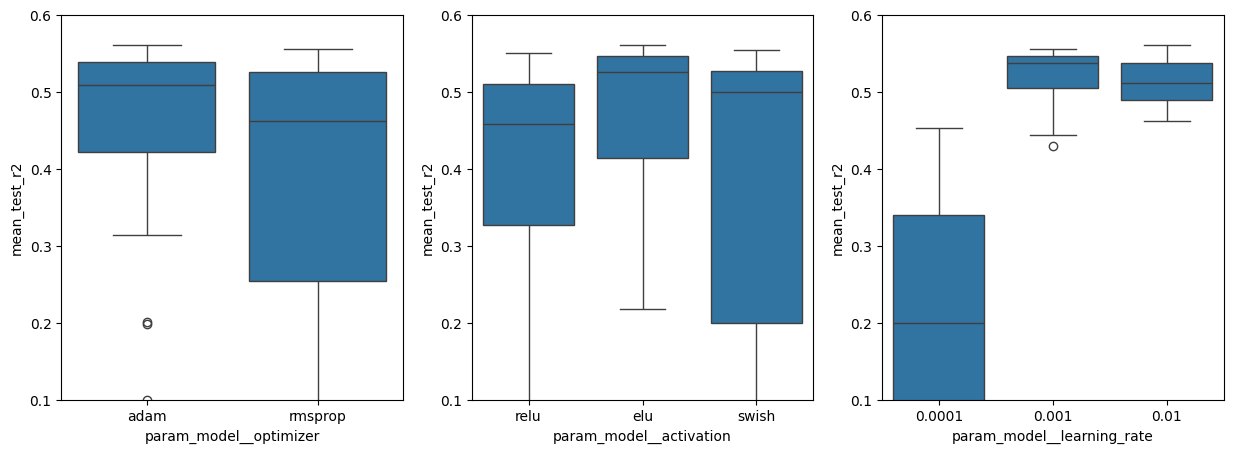

In [7]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.boxplot(data=keras_reg_cv_results_1, x='param_model__optimizer', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=keras_reg_cv_results_1, x='param_model__activation', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=keras_reg_cv_results_1, x='param_model__learning_rate', y='mean_test_r2', ax=ax[2])
ax[0].set_ylim(0.1,0.6)
ax[1].set_ylim(0.1,0.6)
ax[2].set_ylim(0.1,0.6)
plt.show()

In [8]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons': [35, 75, 150],
    'model__layers': [2, 5, 10],
    'model__reduction_factor': [0.3 ,0.5, 0.7],
    'model__optimizer': ['adam'],
    'model__activation': ['elu'],
    'model__learning_rate': [0.001],
    'model__dropout':[0, 0.1],
}
keras_reg_estimators_2, keras_reg_scores_train_2, keras_reg_scores_test_2, keras_reg_cv_results_2 = train(features, targets, keras_sequential_1, keras_reg_param, outer_splits=3, inner_splits=3)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


<Axes: xlabel='param_model__dropout', ylabel='mean_test_r2'>

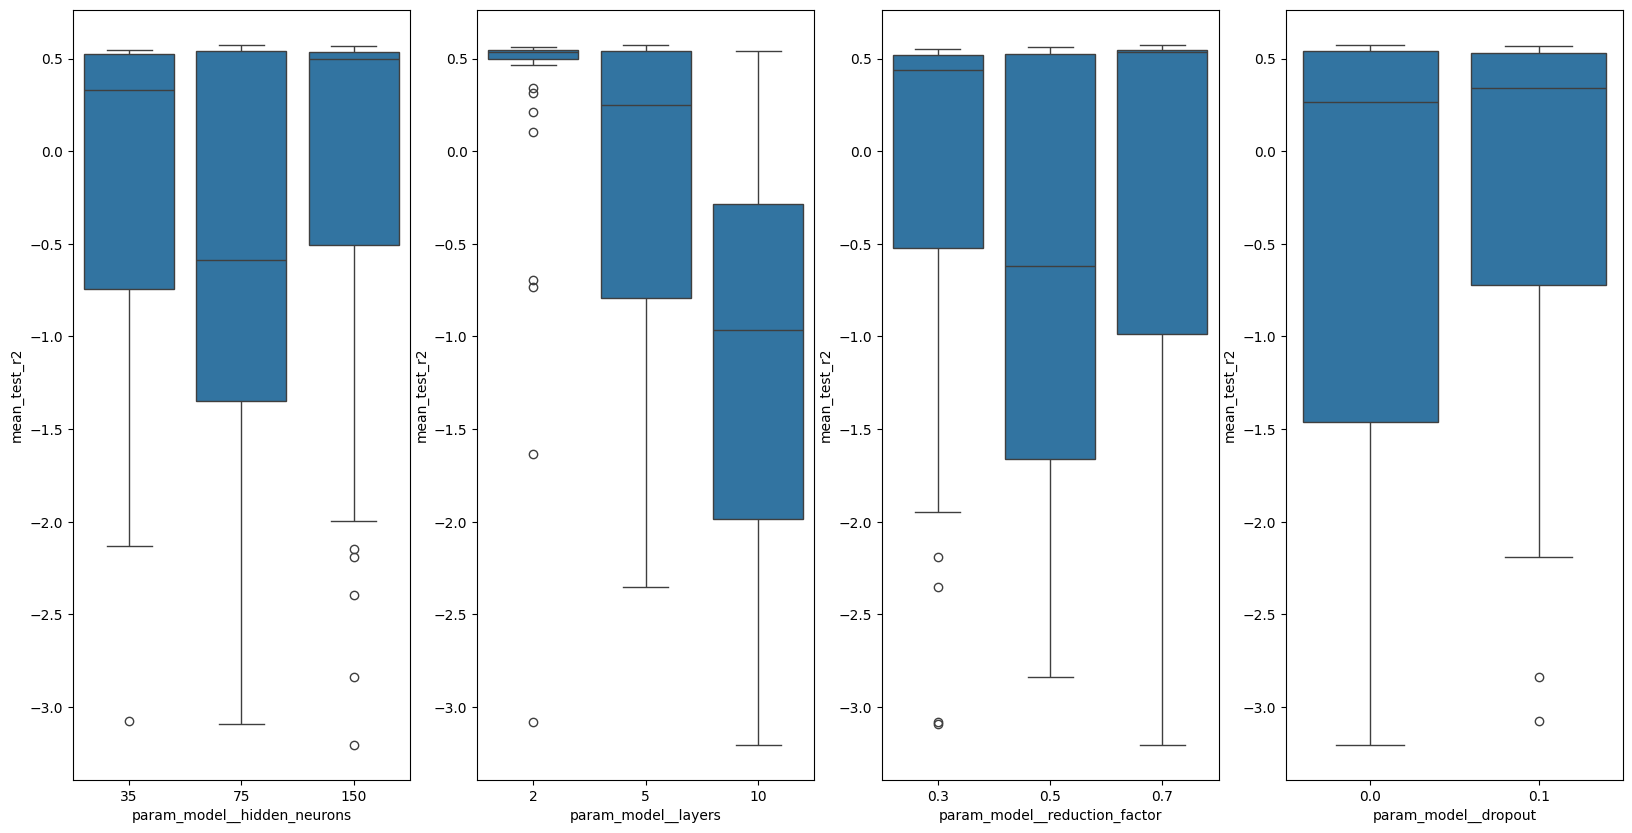

In [9]:
fig, ax = plt.subplots(1,4, figsize=(20,10))
sb.boxplot(data=keras_reg_cv_results_2, x='param_model__hidden_neurons', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=keras_reg_cv_results_2, x='param_model__layers', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=keras_reg_cv_results_2, x='param_model__reduction_factor', y='mean_test_r2', ax=ax[2])
sb.boxplot(data=keras_reg_cv_results_2, x='param_model__dropout', y='mean_test_r2', ax=ax[3])

In [15]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons': [35, 75, 150],
    'model__layers': [2, 5],
    'model__reduction_factor': [0.5, 0.7],
    'model__optimizer': ['adam'],
    'model__activation': ['elu'],
    'model__learning_rate': [0.001],
    'model__dropout':[0, 0.1],
}
keras_reg_estimators_3, keras_reg_scores_train_3, keras_reg_scores_test_3, keras_reg_cv_results_3 = train(features, targets, keras_sequential_1, keras_reg_param, outer_splits=3, inner_splits=3)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


<Axes: xlabel='param_model__dropout', ylabel='mean_test_r2'>

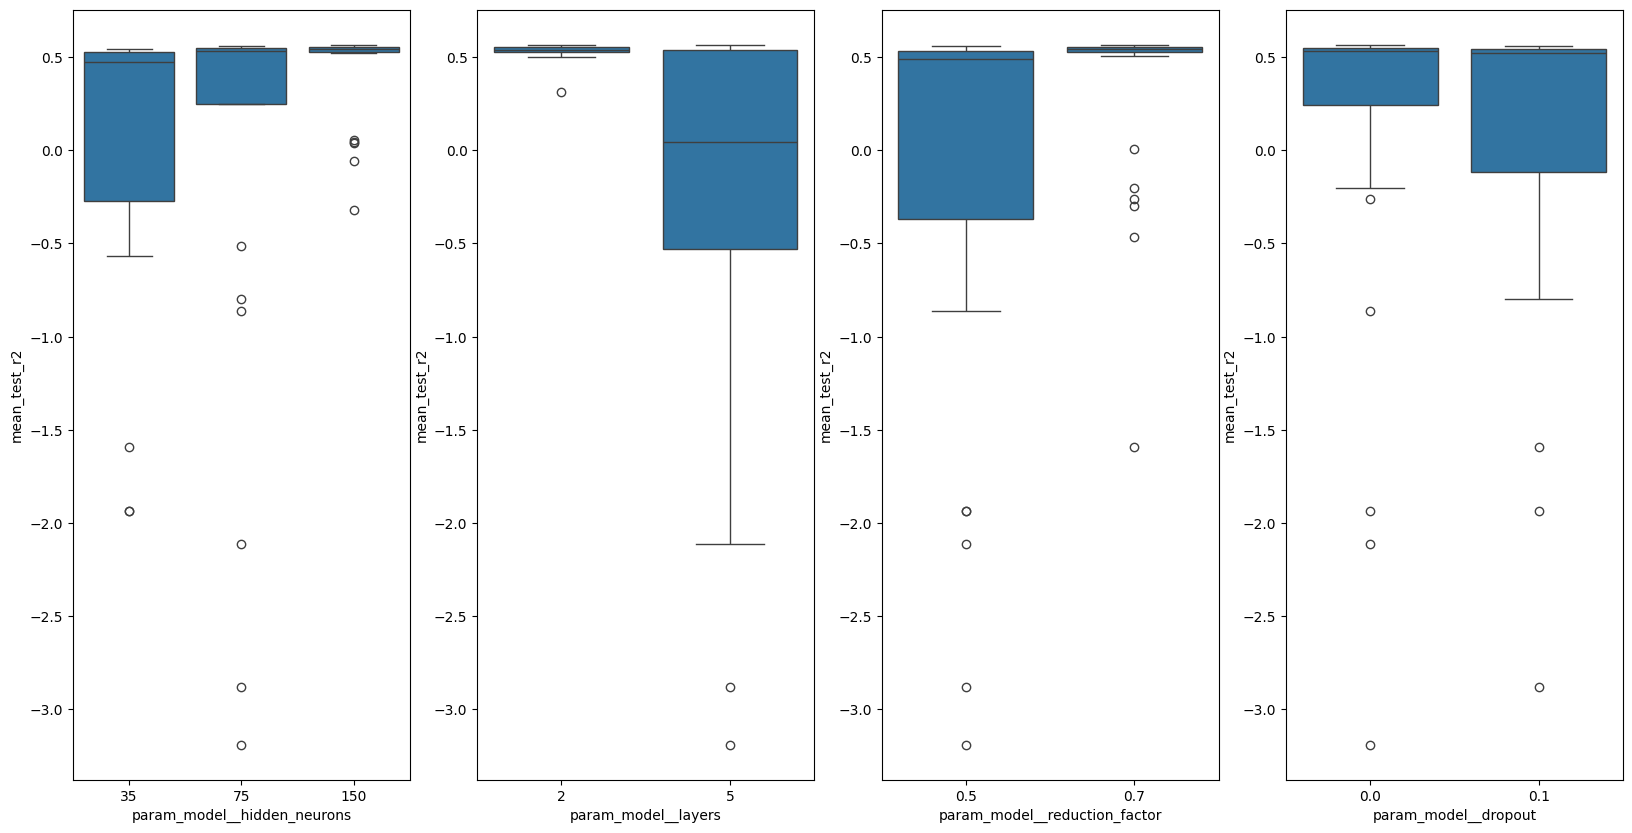

In [16]:
fig, ax = plt.subplots(1,4, figsize=(20,10))
sb.boxplot(data=keras_reg_cv_results_3, x='param_model__hidden_neurons', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=keras_reg_cv_results_3, x='param_model__layers', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=keras_reg_cv_results_3, x='param_model__reduction_factor', y='mean_test_r2', ax=ax[2])
sb.boxplot(data=keras_reg_cv_results_3, x='param_model__dropout', y='mean_test_r2', ax=ax[3])

In [12]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons': [35, 75, 150],
    'model__layers': [2],
    'model__reduction_factor': [0.5, 0.7],
    'model__optimizer': ['adam'],
    'model__activation': ['elu'],
    'model__learning_rate': [0.001],
    'model__dropout':[0, 0.1],
}
keras_reg_estimators_4, keras_reg_scores_train_4, keras_reg_scores_test_4, keras_reg_cv_results_4 = train(features, targets, keras_sequential_1, keras_reg_param, outer_splits=3, inner_splits=3)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


<Axes: xlabel='param_model__dropout', ylabel='mean_test_r2'>

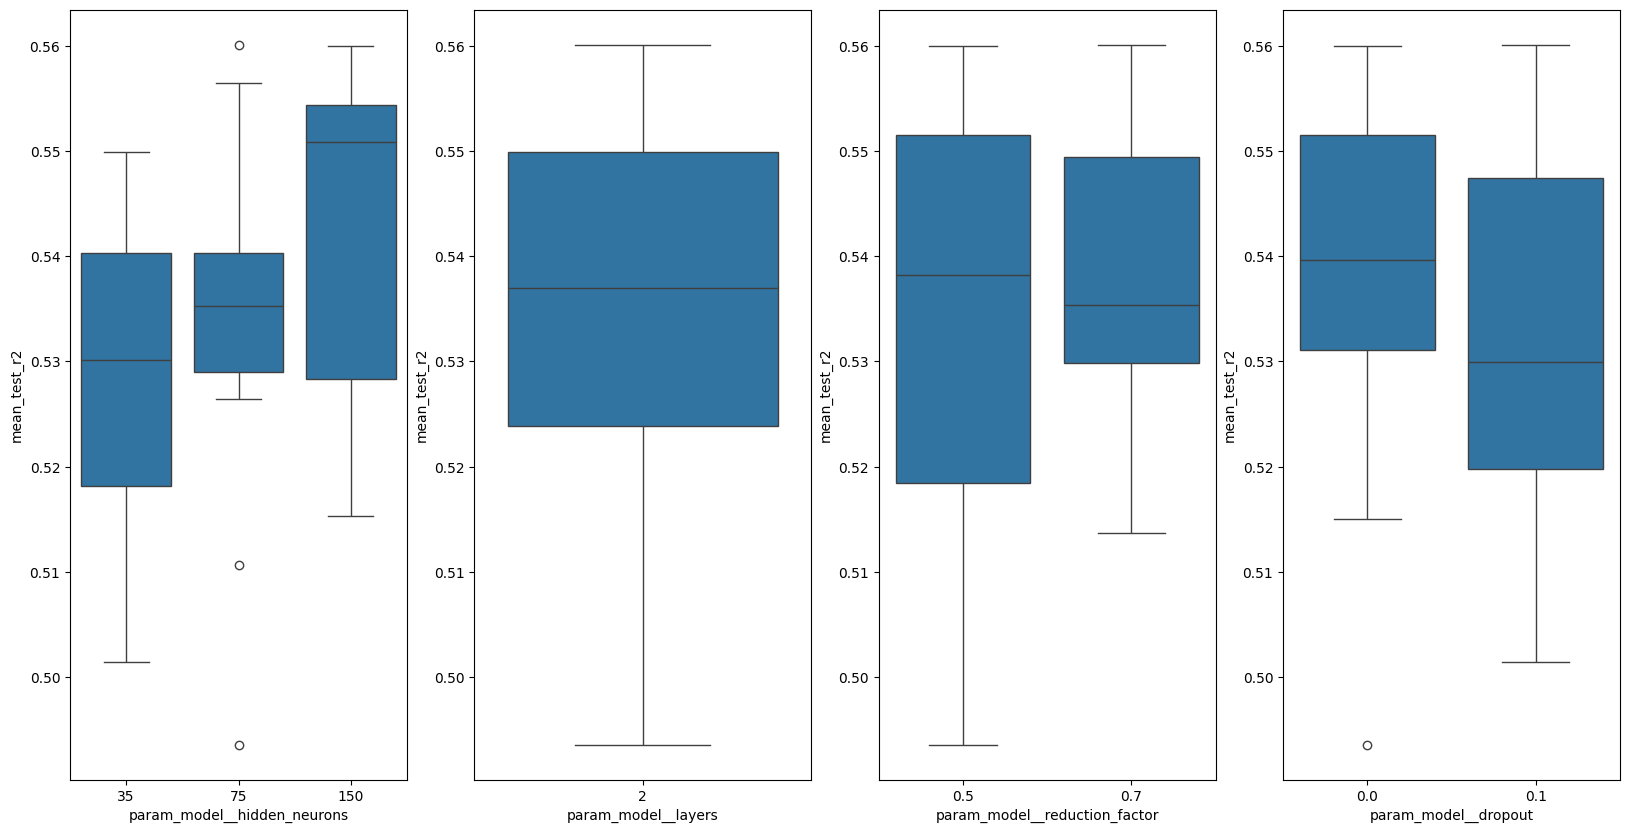

In [ ]:
v

In [17]:
keras_reg_param = {
    'batch_size': [5, 10, 25],
    'epochs': [5, 10, 20, 40],
    'model__hidden_neurons': [150],
    'model__layers': [2],
    'model__reduction_factor': [0.5],
    'model__optimizer': ['rmsprop'],
    'model__activation': ['elu'],
    'model__learning_rate': [0.001],
    'model__dropout':[0, 0.1],
}
keras_reg_estimators_5, keras_reg_scores_train_5, keras_reg_scores_test_5, keras_reg_cv_results_5 = train(features, targets, keras_sequential_1, keras_reg_param, outer_splits=3, inner_splits=3)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


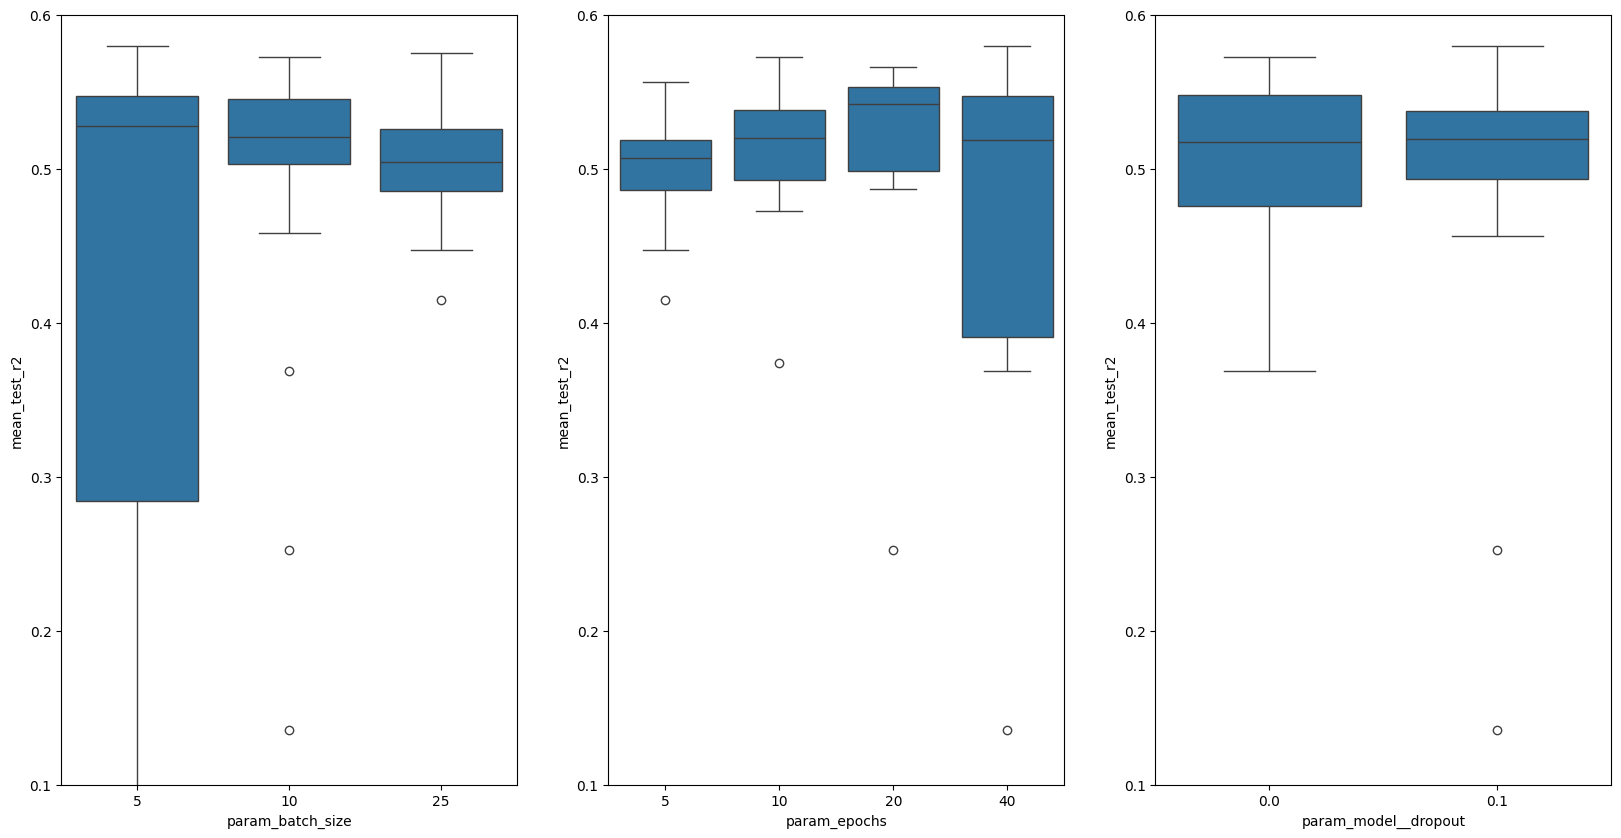

In [21]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
sb.boxplot(data=keras_reg_cv_results_5, x='param_batch_size', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=keras_reg_cv_results_5, x='param_epochs', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=keras_reg_cv_results_5, x='param_model__dropout', y='mean_test_r2', ax=ax[2])
ax[0].set_ylim(0.1,0.6)
ax[1].set_ylim(0.1,0.6)
ax[2].set_ylim(0.1,0.6)
plt.show()

In [22]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [20],
    'model__hidden_neurons': [150],
    'model__layers': [2],
    'model__reduction_factor': [0.5],
    'model__optimizer': ['rmsprop'],
    'model__activation': ['elu'],
    'model__learning_rate': [0.001],
    'model__dropout':[0.1],
}
keras_sequential_estimators_final, keras_sequential_scores_train_final, keras_sequential_scores_test_final, keras_sequential_cv_results_final = train(features, targets, keras_sequential_1, keras_reg_param, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


In [25]:
keras_sequential_scores_test_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.552830,-4.688420,0.549145
std,0.076869,0.355485,0.027703
min,-1.653365,-5.162183,0.519009
25%,-1.601664,-4.834787,0.535799
50%,-1.540517,-4.637838,0.547521
75%,-1.512577,-4.621419,0.549748
max,-1.456025,-4.185871,0.593647


In [24]:
keras_sequential_scores_train_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.505414,-4.605287,0.556895
std,0.063823,0.347385,0.032947
min,-1.604144,-5.183448,0.502783
25%,-1.534354,-4.614514,0.555748
50%,-1.472524,-4.499144,0.563515
75%,-1.466240,-4.467821,0.571570
max,-1.449810,-4.261506,0.590858


In [23]:
def create_model_2(optimizer='adam', activation='swish', hidden_neurons=75, layers=2, dropout=0.1, reduction_factor=0.5, learning_rate=0.001):
    input = Input(shape=(8,))
    x = (Dense(hidden_neurons, activation=activation))(input)
    if(layers > 0):
        hidden_neurons = hidden_neurons*reduction_factor
        if(hidden_neurons >= 1):
            x = (Dense(int(hidden_neurons), activation=activation))(x) + (Dense(int(hidden_neurons), activation=activation))(x)     
    if(layers > 1):
        hidden_neurons = hidden_neurons*reduction_factor
        if(hidden_neurons >= 1):
            x = (Dense(int(hidden_neurons), activation=activation))(x) + (Dense(int(hidden_neurons), activation=activation))(input)
    if(dropout > 0):
        x = (Dropout(dropout))(x)
    x = (Dense(1))(x)
    model = Model(inputs=input, outputs=x)   
    if(optimizer == 'adam'):
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model
keras_model = KerasRegressor(model=create_model_2, verbose=0)

In [ ]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons': [35, 75, 150],
    'model__layers': [0, 1, 2],
    'model__reduction_factor': [0.3 ,0.5, 0.7],
    'model__optimizer': ['adam'],
    'model__activation': ['elu'],
    'model__learning_rate': [0.001],
    'model__dropout':[0, 0.1],
}
keras_reg_estimators_6, keras_reg_scores_train_6, keras_reg_scores_test_6, keras_reg_cv_results_6 = train(features, targets, keras_sequential_1, keras_reg_param, outer_splits=3, inner_splits=3)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


In [80]:
slutt_resultat = pd.DataFrame({
    'Metric': ['Mean absolute error:','Mean squared error:','r2:'],
    'Keras Sequential Train': [keras_sequential_scores_train_final["mean_absolute_error"].mean(), keras_sequential_scores_train_final["mean_squared_error"].mean(), keras_sequential_scores_train_final['r2'].mean()],
    'Keras Sequential Test': [keras_sequential_scores_test_final["mean_absolute_error"].mean(), keras_sequential_scores_test_final["mean_squared_error"].mean(), keras_sequential_scores_test_final['r2'].mean()],
    'Keras Sequential Dropout Train': [model_keras_sequential_dropout_scores_train_final["mean_absolute_error"].mean(), model_keras_sequential_dropout_scores_train_final["mean_squared_error"].mean(), model_keras_sequential_dropout_scores_train_final['r2'].mean()],
    'Keras Sequential Dropout Test': [model_keras_sequential_dropout_scores_test_final["mean_absolute_error"].mean(), model_keras_sequential_dropout_scores_test_final["mean_squared_error"].mean(), model_keras_sequential_dropout_scores_test_final['r2'].mean()],
    'Keras Model Train': [keras_model__scores_train_final["mean_absolute_error"].mean(), keras_model__scores_train_final["mean_squared_error"].mean(), keras_model__scores_train_final['r2'].mean()],
    'Keras Model Test': [keras_model_scores_test_final["mean_absolute_error"].mean(), keras_model_scores_test_final["mean_squared_error"].mean(), keras_model_scores_test_final['r2'].mean()],
    'Keras Model Dropout Train': [keras_model_dropout_scores_train_final["mean_absolute_error"].mean(), keras_model_dropout_scores_train_final["mean_squared_error"].mean(), keras_model_dropout_scores_train_final['r2'].mean()],
    'Keras Model Dropout Test': [keras_model_dropout_scores_test_final["mean_absolute_error"].mean(), keras_model_dropout_scores_test_final["mean_squared_error"].mean(), keras_model_dropout_scores_test_final['r2'].mean()],
})
slutt_resultat.set_index('Metric', inplace=True)
slutt_resultat

,Keras Sequential Train,Keras Sequential Test,Keras Sequential Dropout Train,Keras Sequential Dropout Test,Keras Model Train,Keras Model Test,Keras Model Dropout Train,Keras Model Dropout Test
Metric,,,,,,,,
Mean absolute error:,-1.566423,-1.576872,-1.560652,-1.576230,-1.478923,-1.505568,-1.524869,-1.565661
Mean squared error:,-4.585309,-4.652190,-4.682282,-4.823613,-4.375230,-4.557543,-4.451251,-4.659386
r2:,0.558818,0.552462,0.549502,0.535862,0.579050,0.561488,0.571704,0.551786
